# 加载谷歌云

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

In [ ]:
! kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

In [ ]:
mkdir /root/.kaggle/

In [ ]:
mv /content/kaggle.json /root/.kaggle/

In [ ]:
! unzip /content/lgg-mri-segmentation.zip

In [3]:
! pip install torchsummary

# 加载包

In [4]:
import os
import numpy as np
import pandas as pd
import cv2 
import matplotlib.pyplot as plt 
from glob import glob
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as ff
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torchvision import models
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

# 加载Dataset

## 生成pandas格式的列表

In [5]:
# 数据集路径
# data_dir = "/content/kaggle_3m"   
data_dir = "../input/lgg-mri-segmentation/kaggle_3m"

# 生成mask和img的路径地址array
images_dir = []
masks_dir = []
masks_dir = glob(data_dir + '/*/*_mask*')

for i in masks_dir:
    images_dir.append(i.replace('_mask',''))

print("image的长度{}, image前两张{}".format(len(images_dir), images_dir[:2]))
print("mask的长度{}, mask前两张{}".format(len(masks_dir), masks_dir[:2]))

# 生成dataframe
data = pd.DataFrame({'images':images_dir,'masks':masks_dir})
data

image的长度3929, image前两张['../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8.tif']
mask的长度3929, mask前两张['../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8_mask.tif']


,images,masks
0,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
1,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
2,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
3,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
4,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
...,...,...
3924,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
3925,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
3926,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
3927,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...


## 可视化

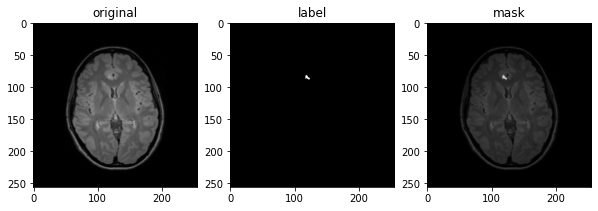

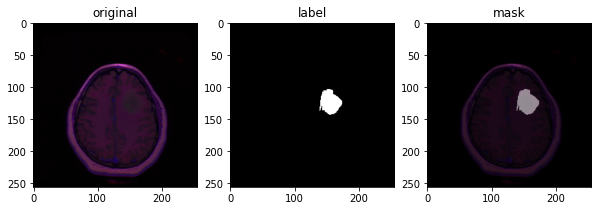

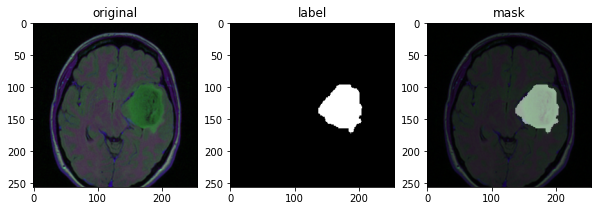

In [6]:
# 可视化第
pic_list=[265,895,95]
for N in pic_list:
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    img = cv2.imread(data.images.iloc[N])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.title("original")
    plt.imshow(img)
    plt.subplot(1,3,2)
    msk=cv2.imread(data.masks.iloc[N])
    msk = cv2.cvtColor(msk, cv2.COLOR_BGR2RGB)
    plt.title("label")
    plt.imshow(msk)
    plt.subplot(1,3,3)
    plt.title("mask")
    plt.imshow(img)
    plt.imshow(msk,alpha=0.5)

In [23]:
img = cv2.imread(data.images.iloc[95])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(data.masks.iloc[95])
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
print("img.shape:" + str(img.shape))
print("mask.shape:" + str(mask.shape))
# 查看值得分布
print("mask值分布:" + str(np.unique(msk)))

img.shape:(256, 256, 3)
mask.shape:(256, 256, 3)
mask值分布:[  0 255]


## 对label编码

In [24]:
class LabelProcessor:
    """对标签图像的编码, 生成1通道的每个像素是类别的array"""

    def __init__(self):
        self.colormap = self.read_color_map()
        self.cm2lbl = self.encode_label_pix(self.colormap)
    
    # 标签编码，返回 1通道 的 已编码的标签 eg: [0000000][0011000][0000000]
    def encode_label_img(self, img):
        data = np.array(img, dtype='int64')
        idx = (data[:, :, 0] * 256 + data[:, :, 1]) * 256 + data[:, :, 2]
        return np.array(self.cm2lbl[idx], dtype='int64')
    
    # 加载color map, eg: 第0个->黑色, 第1个->白色
    @staticmethod
    def read_color_map():  
        colormap = []
        colormap.append([0,0,0])
        colormap.append([255,255,255])
        return colormap
    
    # 标签编码，返回哈希表 eg: cm2lbl[0] = 0, cm2lbl[(255*256+255)*256+256] = 1
    @staticmethod
    def encode_label_pix(colormap):     
        cm2lbl = np.zeros(256 ** 3)
        for i, cm in enumerate(colormap):
            cm2lbl[(cm[0] * 256 + cm[1]) * 256 + cm[2]] = i
        return cm2lbl

## 构建pytorch dataset

In [25]:
class MRIDataset(Dataset):
    """传入pandas格式 eg: img_path = pandas["image"]"""
    
    def __init__(self, img_path, label_path):
        # 读入图片和标签路径, 传入pandas格式 eg: img_path = pandas["image"]
        if not isinstance(img_path, np.ndarray):
            self.img_path = img_path.to_numpy()
            self.label_path = label_path.to_numpy()
        self.labelProcessor = LabelProcessor()

    def __getitem__(self, index):
        # 取每一张
        img = self.img_path[index]
        label = self.label_path[index]
        # 从文件名中读取数据（图片和标签都是png格式的图像数据）
        img = cv2.imread(img, cv2.COLOR_BGR2RGB)
        label = cv2.imread(label) # 3通道一样会读成单通道
        label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)
        # transform
        img, label = self.img_transform(img, label)

        return {'img': img, 'label': label}

    def __len__(self):
        return len(self.img_path)

    def img_transform(self, img, label):
        # 对图片和标签做一些数值处理
        transform_img = transforms.Compose([transforms.ToTensor(),  # 转tensor
                                            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
        
        img = transform_img(img)
        label = self.labelProcessor.encode_label_img(label)
        label = torch.from_numpy(label)

        return img, label

In [26]:
a = MRIDataset(data["images"], data["masks"])
a[0]

{'img': tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -1.9482,  ..., -1.8606, -1.8957, -1.9832],
          [-2.0357, -2.0357, -2.0007,  ..., -1.9482, -1.9307, -2.0007],
          [-2.0357, -2.0357, -2.0182,  ..., -1.9482, -1.9482, -2.0182]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -

# unet

In [28]:
class conv_block(nn.Module):
    """
    Convolution Block 
    """
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):

        x = self.conv(x)
        return x


class up_conv(nn.Module):
    """
    Up Convolution Block
    """
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x


class U_Net(nn.Module):

    def __init__(self, in_ch=3, out_ch=1):
        super(U_Net, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]
        
        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(in_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv2d(filters[0], out_ch, kernel_size=1, stride=1, padding=0)

       # self.active = torch.nn.Sigmoid()

    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)

        d5 = self.Up5(e5)
        d5 = torch.cat((e4, d5), dim=1)

        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        d4 = torch.cat((e3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((e2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((e1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)

        #d1 = self.active(out)

        return out


from torchsummary import summary


if __name__ == "__main__":
    import torch as t

    rgb = t.randn(1, 3, 256, 256).to(device)

    net = U_Net(3, 2).to(device)

    out = net(rgb)

    summary(net,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
        conv_block-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,856
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,584
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14        [-1, 128, 1

# evaluation

In [35]:
def calc_semantic_segmentation_confusion(pred_labels, gt_labels):
    pred_labels = pred_labels.flatten()
    gt_labels = gt_labels.flatten()
    confusion = confusion_matrix(gt_labels, pred_labels)
    return confusion


def calc_semantic_segmentation_iou(confusion):
    iou_denominator = (confusion.sum(axis=1) + confusion.sum(axis=0) - np.diag(confusion))
    iou = (np.diag(confusion) + + 1e-10) / (iou_denominator+ 1e-10)
    return iou

def dice_coeff(pred, target):
    smooth = 1
    num = pred.size(0)

    m1 = pred.view(num, -1).float()  # Flatten
    m2 = target.view(num, -1).float()  # Flatten
    # Then we compute the intersection and the sum of cardinality
    intersection = 2 * torch.sum(m1*m2)
    cardinality = torch.sum(torch.square(m1)) + torch.sum(torch.square(m2))
    # Followed by Dice
    dice = (intersection + smooth) / (cardinality + smooth)
    return dice.mean().data.numpy()


def eval_semantic_segmentation(pred_labels, gt_labels):

    confusion = calc_semantic_segmentation_confusion(pred_labels, gt_labels)
    iou = calc_semantic_segmentation_iou(confusion) 
    pixel_accuracy = (np.diag(confusion).sum()+ 1e-10) / (confusion.sum() + + 1e-10)
    class_accuracy = (np.diag(confusion) + 1e-10) / (np.sum(confusion, axis=1) + 1e-10)
    dice = dice_coeff(pred_labels,gt_labels)

    return {'iou': iou, 
            'miou': np.nanmean(iou),
            'pixel_accuracy': pixel_accuracy,
            'class_accuracy': class_accuracy,
            'mean_class_accuracy': np.nanmean(class_accuracy),
            'dice': dice}

In [36]:
rgb = torch.randn(1, 3, 256, 256)
net = U_Net(3, 2)
out = net(rgb)
out = F.log_softmax(out, dim=1)
out = out.max(dim=1)[1].data.cpu()
true_label = torch.randint(0,2,(1,256,256))

In [37]:
eval_semantic_segmentation(out,true_label)

{'iou': array([0.25145529, 0.40140019]),
 'miou': 0.32642773888162635,
 'pixel_accuracy': 0.5016174316406258,
 'class_accuracy': array([0.33392172, 0.67023686]),
 'mean_class_accuracy': 0.5020792901909464,
 'dice': array(0.5728615, dtype=float32)}

# train

In [38]:
# 测试训练分割

from sklearn.model_selection import train_test_split
train, test = train_test_split(data,test_size=0.2, shuffle=True, random_state=233)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


Load_train = MRIDataset(train["images"], train["masks"])
Load_val= MRIDataset(test["images"], test["masks"])

train_data = DataLoader(Load_train, batch_size=4, shuffle=True, num_workers=1)
val_data = DataLoader(Load_val, batch_size=4, shuffle=True, num_workers=1)

In [39]:
num_class = 2
imput_ch = 3

unet = U_Net(3,2)
unet = unet.to(device)
criterion = nn.NLLLoss().to(device)
optimizer = optim.Adam(unet.parameters(), lr=1e-4)

In [40]:
net = unet.train()

best = [0]
Epoch = 20

train_loss_epoch = []
train_pixcel_acc_epoch = []
train_miou_epoch = []
train_dice_epoch = []
train_mclass_acc_epoch = []

# 训练轮次
for epoch in range(Epoch):

    train_loss = 0
    train_acc = 0
    train_miou = 0
    train_dice = 0
    train_class_acc = 0
    error = 0
    print('Epoch is [{}/{}]'.format(epoch + 1, Epoch))

    # 训练批次
    for i, sample in enumerate(train_data):
        # 载入数据
        img_data = sample['img'].to(device)
        img_label = sample['label'].to(device)
        # 训练
        out = net(img_data)
        out = F.log_softmax(out, dim=1)
        loss = criterion(out, img_label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        # 评估
        pre_label = out.max(dim=1)[1].data.cpu()
        true_label = img_label.data.cpu()
        eval_metrix = eval_semantic_segmentation(pre_label, true_label)
        train_acc += eval_metrix['pixel_accuracy']
        train_miou += eval_metrix['miou']
        if len(eval_metrix['class_accuracy']) < num_class:
            eval_metrix['class_accuracy'] = 0
            train_class_acc = train_class_acc + eval_metrix['class_accuracy']
            error += 1
        else:
            train_class_acc = train_class_acc + eval_metrix['class_accuracy']
        train_dice += eval_metrix['dice']
        # 打印每50次
        if i%100 ==0:
            print('|batch[{}/{}]|batch_loss:{:.9f}|'.format(i + 1, len(train_data), loss.item()))

    metric_description = '|Train Acc|: {:.5f}\n|Train dice|: {:.5f}\n|Train Mean IoU|: {:.5f}\n|Train_class_acc|: {:}'.format(
        train_acc / len(train_data),
        train_dice / len(train_data),
        train_miou / len(train_data),
        train_class_acc / (len(train_data)-error))

    print("-----------------")
    print(metric_description )
    print("-----------------")

    train_loss_epoch.append(train_loss)
    train_pixcel_acc_epoch.append(train_acc / len(train_data))
    train_miou_epoch.append(train_miou / len(train_data))
    train_dice_epoch.append(train_dice / len(train_data))
    train_mclass_acc_epoch.append(list(train_class_acc / (len(train_data)-error)))

    # 储存模型
    if max(best) <= train_miou / len(train_data):
        best.append(train_miou / len(train_data))
        t.save(net.state_dict(), './{}.pth'.format(epoch))


Epoch is [1/20]
|batch[1/786]|batch_loss:0.793232322|
|batch[101/786]|batch_loss:0.227207631|
|batch[201/786]|batch_loss:0.168137699|
|batch[301/786]|batch_loss:0.138711929|
|batch[401/786]|batch_loss:0.094828777|
|batch[501/786]|batch_loss:0.105257437|
|batch[601/786]|batch_loss:0.072399937|
|batch[701/786]|batch_loss:0.049545139|
-----------------
|Train Acc|: 0.98703
|Train dice|: 0.37194
|Train Mean IoU|: 0.63540
|Train_class_acc|: [0.99250696 0.52252866]
-----------------
Epoch is [2/20]
|batch[1/786]|batch_loss:0.062100470|
|batch[101/786]|batch_loss:0.056996897|
|batch[201/786]|batch_loss:0.043442558|
|batch[301/786]|batch_loss:0.044804491|
|batch[401/786]|batch_loss:0.031462111|
|batch[501/786]|batch_loss:0.054978479|
|batch[601/786]|batch_loss:0.057133757|
|batch[701/786]|batch_loss:0.022429701|
-----------------
|Train Acc|: 0.99308
|Train dice|: 0.47261
|Train Mean IoU|: 0.68727
|Train_class_acc|: [0.99805443 0.52567264]
-----------------
Epoch is [3/20]
|batch[1/786]|batch_

In [42]:
len(train_mclass_acc_epoch)

20

# validation

In [43]:
unet = U_Net(3,2)
net.to(device)
net.load_state_dict(torch.load('19.pth'))

<All keys matched successfully>

In [46]:
val_loss_epoch = []
val_pixcel_acc_epoch = []
val_miou_epoch = []
val_dice_epoch = []
val_mclass_acc_epoch = []

In [47]:
def evaluate(model):
    net = model.eval()
    eval_loss = 0
    eval_acc = 0
    eval_miou = 0
    eval_class_acc = 0
    eval_dice = 0
    error = 0

    for j, sample in enumerate(val_data):
        valImg = sample['img'].to(device)
        valLabel = sample['label'].to(device)
        
        out = net(valImg)
        out = F.log_softmax(out, dim=1)
        loss = criterion(out, valLabel)
        
        eval_loss = loss.item() + eval_loss
        # 评估
        pre_label = out.max(dim=1)[1].data.cpu()
        true_label = valLabel.data.cpu()
        eval_metrics = eval_semantic_segmentation(pre_label, true_label)
        eval_acc = eval_metrics['mean_class_accuracy'] + eval_acc
        eval_miou = eval_metrics['miou'] + eval_miou
        
        if len(eval_metrix['class_accuracy']) < num_class:
            eval_metrix['class_accuracy'] = 0
            eval_class_acc = eval_class_acc + eval_metrix['class_accuracy']
            error += 1
        else:
            eval_class_acc =  eval_metrics['class_accuracy'] + eval_class_acc
        eval_dice += eval_metrix['dice']

    val_str = '|val Acc|: {:.5f}\n|val dice|: {:.5f}\n|val Mean IoU|: {:.5f}\n|val_class_acc|: {:}'.format(
        eval_acc / len(val_data),
        eval_dice / len(val_data),
        eval_miou / len(val_data),
        eval_class_acc / (len(val_data)-error))
    
    val_loss_epoch.append(eval_loss)
    val_pixcel_acc_epoch.append(eval_acc / len(val_data))
    val_miou_epoch.append(eval_miou / len(val_data))
    val_dice_epoch.append(eval_dice / len(val_data))
    val_mclass_acc_epoch.append(list(eval_class_acc / (len(val_data)-error)))
    
    print(val_str)

In [48]:
evaluate(net)

|val Acc|: 0.92934
|val dice|: 0.96911
|val Mean IoU|: 0.88310
|val_class_acc|: [0.99890581 0.85978206]


In [49]:
len(val_loss_epoch)

1

# predict

In [61]:
colormap = []
colormap.append([0,0,0])
colormap.append([255,255,255])
cm = np.array(colormap).astype('uint8')

In [91]:
test_img = test["images"].to_numpy()[22:26]
test_label = test["masks"].to_numpy()[22:26]
pd_aa = pd.DataFrame({'images':test_img,'masks':test_label})
Load_val= MRIDataset(pd_aa['images'], pd_aa['masks'])
val_data = DataLoader(Load_val, batch_size=4, shuffle=False, num_workers=1)

In [92]:
smaples = iter(val_data)
sample = smaples.next()

In [93]:
np.unique(sample["label"])

array([0, 1])

In [94]:
sample["img"].shape

torch.Size([4, 3, 256, 256])

In [95]:
valImg = sample['img'].to(device)
valLabel = sample['label'].long().to(device)
out = net(valImg)
out = F.log_softmax(out, dim=1)
pre_label = out.max(1)[1].squeeze().cpu().data.numpy()
pre = cm[pre_label]

In [96]:
true_pic = cm[sample["label"]]
true_pic.shape

(4, 256, 256, 3)

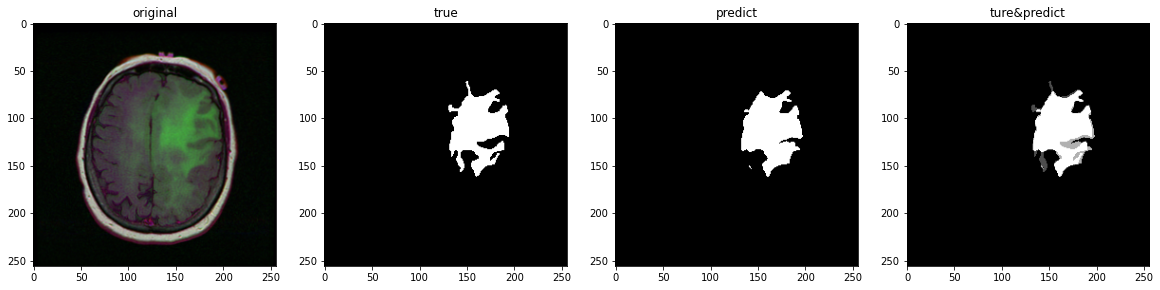

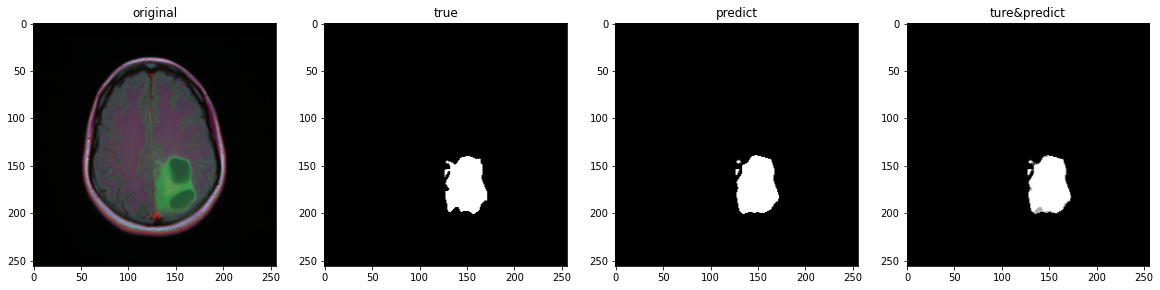

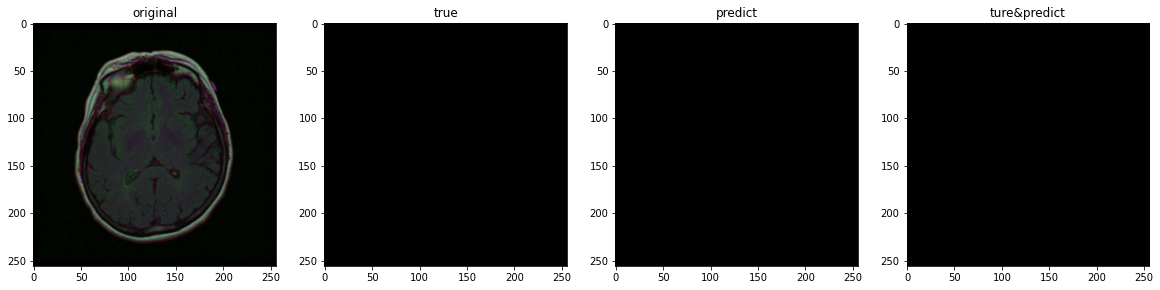

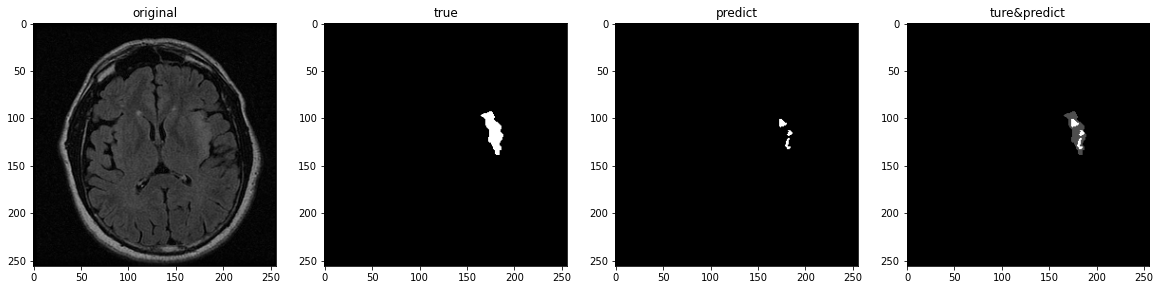

In [97]:
for N in range(4):
    plt.figure(figsize=(20,20))
    plt.subplot(1,4,1)
    img=cv2.imread(test_img[N])
    plt.title("original")
    plt.imshow(img)
    plt.subplot(1,4,2)
    plt.title("true")
    plt.imshow(true_pic[N])
    plt.subplot(1,4,3)
    plt.title("predict")
    plt.imshow(pre[N])
    plt.subplot(1,4,4)
    plt.title("ture&predict")
    plt.imshow(true_pic[N])
    plt.imshow(pre[N],alpha=0.7,cmap="jet")

In [98]:
epoch = np.arange(1,21).reshape(20,1)

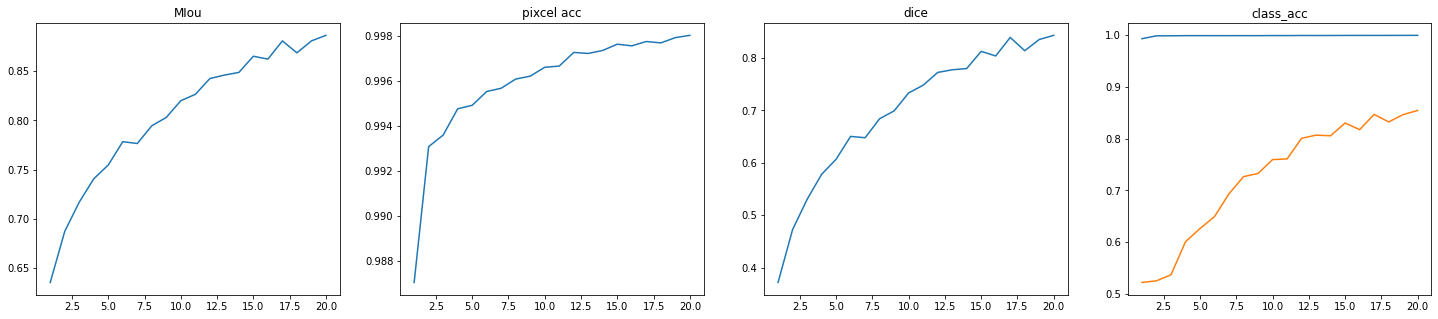

In [82]:
plt.figure(figsize=(25,5))
plt.subplot(1,4,1)
plt.plot(epoch,train_miou_epoch)
plt.title("MIou")
plt.subplot(1,4,2)
plt.plot(epoch,train_pixcel_acc_epoch)
plt.title("pixcel acc")
plt.subplot(1,4,3)
plt.plot(epoch,train_dice_epoch)
plt.title("dice")
plt.subplot(1,4,4)
plt.plot(epoch,train_mclass_acc_epoch)
plt.title("class_acc")
plt.show()